/home/zhaoxiandong/projects/caffe/python



/home/zhaoxiandong/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(3, 416, 416)
500 335


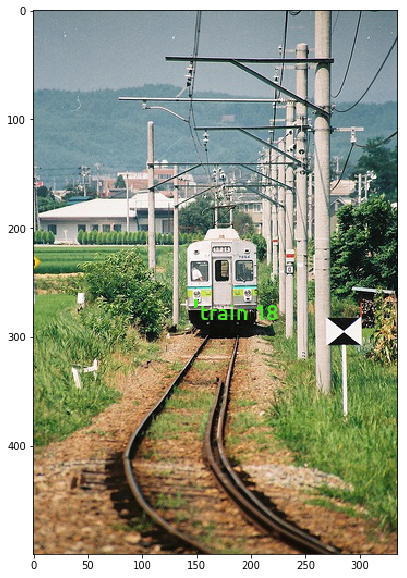

In [1]:
# requred Python environment:
import os
print os.popen("echo $PYTHONPATH").read()

# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import caffe
import numpy as np

from PIL import Image, ImageDraw, ImageFont

import matplotlib.image as mpimg
import numpy as np



class Box(object):
    def __init__(self, x, y, w, h, prob=0.0, category=-1):
        self.x = x
        self.y = y
        self.h = h
        self.w = w
        self.prob = prob
        self.category = category

    def __str__(self):
        return "({0},{1},{2},{3},{4},{5})".format(self.x, self.y, self.w, self.h, self.prob, self.category)


def get_names_from_file(filename):
    result = []
    fd = file(filename, 'r')
    for line in fd.readlines():
        result.append(line.replace('\n', ''))
    return result


def get_color_from_file(filename):
    colors = []
    fd = file(filename, 'r')
    for line in fd.readlines():
        words = line.split(r',')
        color = (int(words[0]), int(words[1]), int(words[2]))
        colors.append(color)
    return colors


def draw_image(pic_name, new_len, boxes, namelist_file):
    name_list = get_names_from_file(namelist_file)
    color_list = get_color_from_file('data/PascalVOCData/ink.color')
    im = Image.open(pic_name)
    draw = ImageDraw.Draw(im)
    lena = mpimg.imread(pic_name)
    height, width = lena.shape[:2]
    print height, width
    for box in boxes:
        x = box.x
        y = box.y
        h = box.h
        w = box.w
        left = (x - w / 2) * new_len
        left = left - (new_len - width) / 2
        right = (x + w / 2) * new_len
        right = right - (new_len - width) / 2
        top = (y - h / 2) * new_len
        top = top - (new_len - height) / 2
        bot = (y + h / 2) * new_len
        bot = bot - (new_len - height) / 2
        if left < 0:
            left = 0
        if right > width - 1:
            right = width - 1
        if top < 0:
            top = 0
        if bot > height - 1:
            bot = height - 1
        category = name_list[box.category]
        color = color_list[box.category % len(color_list)]
        draw.line((left, top, right, top), fill=color, width=2)
        draw.line((right, top, right, bot), fill=color, width=2)
        draw.line((left, top, left, bot), fill=color, width=2)
        draw.line((left, bot, right, bot), fill=color, width=2)
        font_size = 20
        my_font = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-M.ttf", size=font_size)
        draw.text([left + 5, top], category, font=my_font, fill=color)
#     im.show()
    plt.imshow(im)

def fill_image(image):
    height = image.shape[0]
    width = image.shape[1]
    if height == width:
        image_fill = image
        new_len = height
    if height > width:
        image_fill = np.empty(height * height * 3)
        image_fill.fill(0.5)
        image_fill = image_fill.reshape([height, height, 3])
        diff = height - width
        diff = diff / 2
        image_fill[:, diff:diff + width, :] = image[:,:,:]
        new_len = height
    if height < width:
        image_fill = np.empty(width * width * 3)
        image_fill.fill(0.5)
        image_fill = image_fill.reshape([width, width, 3])
        diff = width - height
        diff = diff / 2
        image_fill[diff:diff + height, :, :] = image[:,:,:]
        new_len = width
    return new_len, image_fill

def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

caffe.set_device(1)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
pic_name = 'data/PascalVOCData/VOCdevkit/VOC2007/JPEGImages/000002.jpg'
image = caffe.io.load_image(pic_name)
new_len, image = fill_image(image)
plt.imshow(image)

transformer = caffe.io.Transformer({'data': (1, 3, 416, 416)})
transformer.set_transpose('data', (2, 0, 1))  # move image channels to outermost dimension
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR
transformed_image = transformer.preprocess('data', image)
print transformed_image.shape

model_def = 'models/darknet_yolov2/train_val-voc.2.0_step2.prototxt'
# model_weights = '/home/zhaoxiandong/Models/darknet_yolo_voc/yolo-voc.2.0.caffemodel'
model_weights = 'models/darknet_yolov2/yolo-voc_step2_iter_53.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)
net_train = caffe.Net(model_def, model_weights, caffe.TRAIN)
# net.blobs['data'].reshape(1, 3, 416, 416)
# net.blobs['data'].data[...] = transformed_image
output = net.forward()
net_train.forward()

# model_def = '/home/zhaoxiandong/Models/darknet_yolo_voc_only_conv_fixpoint/deploy-voc.2.0.prototxt'

probs = net.blobs['region_output'].data[0][0]
# print probs

boxes = []
for prob in probs:
    box = Box(prob[0], prob[1], prob[2], prob[3], prob[4], int(prob[5]))
    boxes.append(box)

draw_image(pic_name, new_len, boxes=boxes, namelist_file='data/PascalVOCData/label_map.txt')

In [2]:
feat = net.blobs['eval_det'].data
print feat.shape
print feat
print net.blobs['permute_conv22'].data[0, 5, 7, 25:50]
print net.blobs['permute_conv22'].data.shape
print net.blobs['region_output'].data

(1, 3, 20)
[[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
    1.  0.]]]
[ 0.1587709   0.0287444   0.01692373 -0.0119935  -8.55013561 -0.36797866
 -0.77781802 -0.6174621  -0.2589685  -0.58607668 -0.45552006 -0.34940901
 -0.33029613 -0.2245692  -0.38025817 -0.41540706 -0.38416198 -0.6814478
 -1.30767632  0.17208201 -0.6205014   0.13806552 -0.80962443  7.28683949
  0.09092058]
(1, 13, 13, 125)
[[[[  0.50977379   0.50054419   0.10260233   0.16464747   0.97201008  18.
      0.        ]]]]


In [7]:
net.forward()

{'det_loss': array([ 0.01904943], dtype=float32),
 'eval_det': array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.]]], dtype=float32)}

(42,)
[18.     0.     0.51   0.501  0.136  0.202 -1.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.   ]
(3, 416, 416)


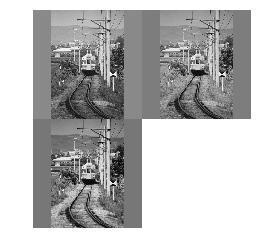

In [2]:
feat1 = net.blobs['data'].data[0, :36]
label = net.blobs['label'].data[0]
print label.shape
print label
print(feat1.shape)
vis_square(feat1)

(36, 13, 13)


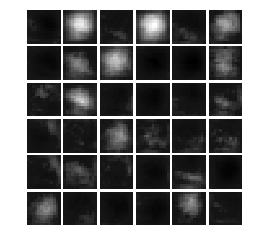

In [16]:
feat = net.blobs['conv20'].data[0, :36]
print(feat.shape)
vis_square(feat)

(36, 13, 13)


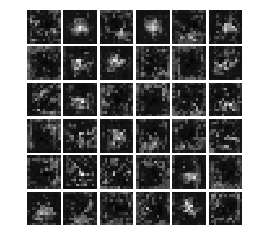

In [15]:
feat = net_train.blobs['conv20'].data[0, :36]
print(feat.shape)
vis_square(feat)

In [27]:
feat_test = net.blobs['conv1'].data[0, :36]
feat_train = net_train.blobs['conv1'].data[0, :36]
mse_loss = ((feat_test - feat_train) ** 2).mean()
print(mse_loss)

0.0057089534
